In [1]:
import calliope

In [2]:
try:
    calliope.set_log_level('INFO')
except:
    calliope.set_log_verbosity('INFO')
model = calliope.Model('model.yaml')
model.run()

[2020-08-31 12:15:22] INFO     Model: initialising
[2020-08-31 12:15:22] WARNING  C:\Users\Amin\Anaconda3\lib\site-packages\calliope\core\preprocess\model_run.py:233: FutureWarning:

There will be no default cost class for the objective function in v0.7.0 (currently "monetary" with a weight of 1). Explicitly specify the cost class(es) you would like to use under `run.objective_options.cost_class`. E.g. `{"monetary": 1}` to replicate the current default.


[2020-08-31 12:15:23] INFO     Model: preprocessing stage 1 (model_run)
[2020-08-31 12:15:23] INFO     NumExpr defaulting to 4 threads.
[2020-08-31 12:15:23] INFO     Model: preprocessing stage 2 (model_data)
[2020-08-31 12:15:24] INFO     Model: preprocessing complete
[2020-08-31 12:15:24] INFO     Backend: starting model run
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lifetime) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' t

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (resource_unit) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (resource_unit) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (resource_unit) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATE

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_remotes) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_remotes) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_remotes) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPREC

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (colors) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (colors) to be 'Any', you can
suppress this warning by explicitly specifying 'within=Any' to the
Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (colors) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (inheritance) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (inheritance) to be 'Any', you
can suppress this warning by explicitly specifying 'within=Any' to the
Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (inheritance) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (names) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (names) to be 'Any', you can
suppress this warning by explicitly specifying 'within=Any' to the
Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (names) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain for 

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_carriers) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_carriers) to be
'Any', you can suppress this warning by explicitly specifying
'within=Any' to the Param constructor.  (deprecated in 5.6.9, will be
removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_carriers) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] 

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_techs) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_techs) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  DEPRECATED: The default domain for Param objects is 'Any'.  However,
we will be changing that default to 'Reals' in the future.  If you
really intend the domain of this Param (lookup_loc_techs) to be 'Any',
you can suppress this warning by explicitly specifying 'within=Any' to
the Param constructor.  (deprecated in 5.6.9, will be removed in 6.0)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (lookup_loc_techs) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0)
[2020-08-31 12:15:25] WARNING  

In [6]:
import cal_graph as CG
amin=CG.C_Graph(model=model,ex_path=r'Graph_inputs.xlsx',unit='kW')



[2020-08-31 12:16:13] WARNING  C:\Users\Amin\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()




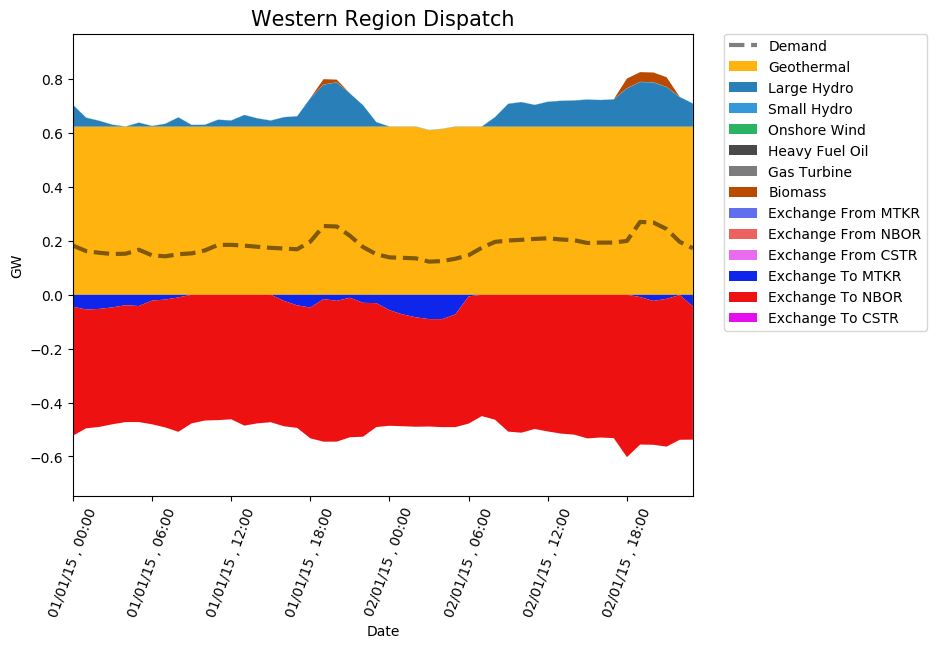

In [7]:
amin.node_dispatch(unit='GW',x_ticks='date')

In [ ]:
#amin.cap_f_plot(v_round=3)
amin.ins_cap_plot(kind='bar')


In [ ]:
amin.node_pie(kind='absolute',unit='GWh',v_round=3)

In [ ]:
amin.cap_f_plot(kind='bar',v_round=4)

In [ ]:
imp

In [ ]:
imp = amin.imports

In [ ]:
imp.index.month_name()

In [ ]:
amin.a.index.month_name()

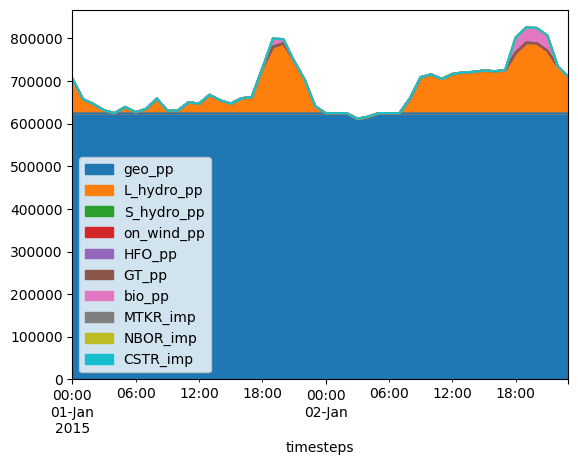

In [11]:
amin.a.plot(kind='area')